In [0]:
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.applications import NASNetLarge, ResNet50, VGG16
from keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt

import os 
import zipfile
from google.colab import drive
drive.mount('/content/drive')


In [5]:
root = '/content/drive/My Drive/'
log_path = os.path.join(root, 'logs')
weights_path = os.path.join(root, 'weights', 'weights_temp.h5')
models_path = os.path.join(root, 'models')
os.listdir(root)


['Personal',
 'School',
 'Notability',
 'Copy of Tasks.gsheet',
 'Three Kings.gdoc',
 'Campaign FINAL.pdf',
 'References complete .pdf',
 '2_slides.pdf',
 'H.Cury Resume.docx',
 'NASA SEE 2020.gdoc',
 '3 pages for SD1.gdoc',
 '15 pages for SD1.gdoc',
 'Colab Notebooks',
 'Break even.gsheet',
 'Copy of Budget.gsheet',
 'Budget.gsheet',
 'COP4331-0001-ProjectGroup19-Deliverable5.gdoc',
 'Individual Lessons Learned.gdoc',
 'RuTanks7000_v1.zip',
 'RuTanks7000_v1',
 '__MACOSX',
 'weights',
 'models']

In [0]:
#with zipfile.ZipFile(os.path.join(root, 'RuTanks7000_v1.zip'), 'r') as zip_ref:
    #zip_ref.extractall(root)

In [15]:
from tensorflow.python.client import device_lib
for x in device_lib.list_local_devices():
   if x.device_type == "GPU":
     print("***** GPU Information *****")
     print("Device Name: " , x.name)
     print("Memory Limit: " , "%.2f" % float(x.memory_limit/(1000*1000*1000)), "GB")
     print("Description: " , x.physical_device_desc)

***** GPU Information *****
Device Name:  /device:GPU:0
Memory Limit:  15.96 GB
Description:  device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
data_path = os.path.join(root, 'RuTanks7000_v1/')
os.listdir(data_path)

['test', 'train']

In [8]:
class_labels = ["Background", "BMP2", "Buk-M1-2", "T14", "T90", "ZSU23"]
num_classes = len(class_labels)
input_height = 331
input_width = 331
batch_size = 64
learning_rate = 0.0001
lr_decay = 0.0001
epochs = 5
patience = 1
factor = 0.5
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(os.path.join(data_path, 'train'),
    target_size=(input_height, input_width),
    batch_size=batch_size,
    shuffle=True,
    classes=class_labels,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(os.path.join(data_path, 'test'),
    target_size=(input_height, input_width),
    batch_size=1,
    shuffle=True,
    classes=class_labels,
    class_mode='categorical')

Found 42000 images belonging to 6 classes.
Found 90 images belonging to 6 classes.


In [9]:
def plot_history(history):
  # Function to plot loss and accuracy history of model
  history_dict = history.history
  epochs_range = range(1, epochs+1)

  # Get loss history
  loss_values = history_dict['loss']
  test_loss_values = history_dict['val_loss']

  # Get accuracy history
  acc_values = history_dict['acc']
  test_acc_values = history_dict['val_acc']

  # plot loss
  plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
  plt.plot(epochs_range, test_loss_values, 'ro', label='Test loss')
  plt.title('Training and test loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # plot accuracy
  plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
  plt.plot(epochs_range, test_acc_values, 'ro', label='Test accuracy')
  plt.title('Training and test accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

feature_extraction = NASNetLarge(weights='imagenet', include_top=False, input_shape=(input_height, input_width, 3))
model = models.Sequential()
model.add(feature_extraction)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

print("trainable layers bevor freezing:", int(len(model.trainable_weights)/2))
feature_extraction.trainable = False
print("trainable layers after freezing:", int(len(model.trainable_weights)/2))
model.summary()















343613440/343610240 [==============================] - 25s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
trainable layers bevor freezing: 510
trainable layers after freezing: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 4032)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1032448   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)           

In [10]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate, decay=lr_decay), metrics=['acc'])

callbacks = [ModelCheckpoint(filepath=weights_path, save_weights_only=True, monitor='val_acc', verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_acc', factor=factor, patience=patience, verbose=1)]

In [9]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=42000 // (batch_size *  10),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_generator,
    validation_steps=90,
    verbose=True)

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


 1/65 [..............................] - ETA: 42:43 - loss: 0.9490 - acc: 0.6719

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 579 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/65 [..............................] - ETA: 40:51 - loss: 0.9677 - acc: 0.6953

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 203 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/65 [>.............................] - ETA: 40:39 - loss: 0.9741 - acc: 0.6875

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 290 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/65 [>.............................] - ETA: 39:28 - loss: 0.9450 - acc: 0.7109

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 156 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/65 [=>............................] - ETA: 38:38 - loss: 0.9654 - acc: 0.7031

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 258 could not be retrieved. It could be because a worker has died.
  UserWarning)


 6/65 [=>............................] - ETA: 38:11 - loss: 0.9581 - acc: 0.7083

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 442 could not be retrieved. It could be because a worker has died.
  UserWarning)


 8/65 [==>...........................] - ETA: 32:32 - loss: 0.9839 - acc: 0.6953

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 263 could not be retrieved. It could be because a worker has died.
  UserWarning)


 9/65 [===>..........................] - ETA: 32:28 - loss: 0.9781 - acc: 0.6944

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 410 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/65 [===>..........................] - ETA: 32:10 - loss: 0.9672 - acc: 0.7016

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 536 could not be retrieved. It could be because a worker has died.
  UserWarning)


11/65 [====>.........................] - ETA: 31:53 - loss: 0.9629 - acc: 0.7003

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 170 could not be retrieved. It could be because a worker has died.
  UserWarning)


12/65 [====>.........................] - ETA: 31:28 - loss: 0.9605 - acc: 0.7018

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 379 could not be retrieved. It could be because a worker has died.
  UserWarning)


13/65 [=====>........................] - ETA: 31:06 - loss: 0.9608 - acc: 0.6983

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 221 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/65 [=====>........................] - ETA: 30:39 - loss: 0.9581 - acc: 0.7042

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 365 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/65 [=====>........................] - ETA: 30:10 - loss: 0.9474 - acc: 0.7083

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 558 could not be retrieved. It could be because a worker has died.
  UserWarning)


16/65 [======>.......................] - ETA: 29:41 - loss: 0.9473 - acc: 0.7080

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 82 could not be retrieved. It could be because a worker has died.
  UserWarning)


17/65 [======>.......................] - ETA: 29:11 - loss: 0.9428 - acc: 0.7096

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 608 could not be retrieved. It could be because a worker has died.
  UserWarning)


18/65 [=======>......................] - ETA: 28:39 - loss: 0.9339 - acc: 0.7127

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 373 could not be retrieved. It could be because a worker has died.
  UserWarning)


19/65 [=======>......................] - ETA: 28:06 - loss: 0.9282 - acc: 0.7146

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 363 could not be retrieved. It could be because a worker has died.
  UserWarning)


20/65 [========>.....................] - ETA: 27:34 - loss: 0.9285 - acc: 0.7117

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 166 could not be retrieved. It could be because a worker has died.
  UserWarning)


21/65 [========>.....................] - ETA: 27:02 - loss: 0.9202 - acc: 0.7143

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 64 could not be retrieved. It could be because a worker has died.
  UserWarning)


22/65 [=========>....................] - ETA: 26:28 - loss: 0.9155 - acc: 0.7159

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 378 could not be retrieved. It could be because a worker has died.
  UserWarning)


23/65 [=========>....................] - ETA: 25:53 - loss: 0.9116 - acc: 0.7167

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 302 could not be retrieved. It could be because a worker has died.
  UserWarning)


24/65 [==========>...................] - ETA: 25:16 - loss: 0.9081 - acc: 0.7174

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 469 could not be retrieved. It could be because a worker has died.
  UserWarning)


25/65 [==========>...................] - ETA: 24:42 - loss: 0.9031 - acc: 0.7212

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 351 could not be retrieved. It could be because a worker has died.
  UserWarning)


26/65 [===========>..................] - ETA: 24:06 - loss: 0.9043 - acc: 0.7200

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 559 could not be retrieved. It could be because a worker has died.
  UserWarning)


27/65 [===========>..................] - ETA: 23:29 - loss: 0.9051 - acc: 0.7182

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 419 could not be retrieved. It could be because a worker has died.
  UserWarning)


28/65 [===========>..................] - ETA: 22:53 - loss: 0.9069 - acc: 0.7171

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 509 could not be retrieved. It could be because a worker has died.
  UserWarning)


29/65 [============>.................] - ETA: 22:16 - loss: 0.9089 - acc: 0.7150

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 631 could not be retrieved. It could be because a worker has died.
  UserWarning)


30/65 [============>.................] - ETA: 21:39 - loss: 0.9091 - acc: 0.7130

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 501 could not be retrieved. It could be because a worker has died.
  UserWarning)


31/65 [=============>................] - ETA: 21:04 - loss: 0.9081 - acc: 0.7142

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 546 could not be retrieved. It could be because a worker has died.
  UserWarning)


32/65 [=============>................] - ETA: 20:27 - loss: 0.9082 - acc: 0.7144

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 583 could not be retrieved. It could be because a worker has died.
  UserWarning)


33/65 [==============>...............] - ETA: 19:50 - loss: 0.9099 - acc: 0.7116

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 345 could not be retrieved. It could be because a worker has died.
  UserWarning)


34/65 [==============>...............] - ETA: 19:13 - loss: 0.9049 - acc: 0.7123

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 246 could not be retrieved. It could be because a worker has died.
  UserWarning)


35/65 [===============>..............] - ETA: 18:36 - loss: 0.9061 - acc: 0.7112

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 12 could not be retrieved. It could be because a worker has died.
  UserWarning)


36/65 [===============>..............] - ETA: 17:59 - loss: 0.8994 - acc: 0.7144

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 484 could not be retrieved. It could be because a worker has died.
  UserWarning)


37/65 [================>.............] - ETA: 17:23 - loss: 0.8976 - acc: 0.7154

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 457 could not be retrieved. It could be because a worker has died.
  UserWarning)


39/65 [=================>............] - ETA: 15:45 - loss: 0.8907 - acc: 0.7171

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 147 could not be retrieved. It could be because a worker has died.
  UserWarning)


40/65 [=================>............] - ETA: 15:11 - loss: 0.8931 - acc: 0.7152

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 150 could not be retrieved. It could be because a worker has died.
  UserWarning)


41/65 [=================>............] - ETA: 14:36 - loss: 0.8911 - acc: 0.7161

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 223 could not be retrieved. It could be because a worker has died.
  UserWarning)


42/65 [==================>...........] - ETA: 14:00 - loss: 0.8889 - acc: 0.7176

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 174 could not be retrieved. It could be because a worker has died.
  UserWarning)


43/65 [==================>...........] - ETA: 13:24 - loss: 0.8876 - acc: 0.7180

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 163 could not be retrieved. It could be because a worker has died.
  UserWarning)


44/65 [===================>..........] - ETA: 12:49 - loss: 0.8842 - acc: 0.7205

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 171 could not be retrieved. It could be because a worker has died.
  UserWarning)


45/65 [===================>..........] - ETA: 12:12 - loss: 0.8825 - acc: 0.7222

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 219 could not be retrieved. It could be because a worker has died.
  UserWarning)


46/65 [====================>.........] - ETA: 11:36 - loss: 0.8783 - acc: 0.7228

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 654 could not be retrieved. It could be because a worker has died.
  UserWarning)


47/65 [====================>.........] - ETA: 11:00 - loss: 0.8769 - acc: 0.7237

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 643 could not be retrieved. It could be because a worker has died.
  UserWarning)


48/65 [=====================>........] - ETA: 10:24 - loss: 0.8743 - acc: 0.7249

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 560 could not be retrieved. It could be because a worker has died.
  UserWarning)


49/65 [=====================>........] - ETA: 9:47 - loss: 0.8768 - acc: 0.7248 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 37 could not be retrieved. It could be because a worker has died.
  UserWarning)


50/65 [======================>.......] - ETA: 9:11 - loss: 0.8726 - acc: 0.7272

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 210 could not be retrieved. It could be because a worker has died.
  UserWarning)


52/65 [=======================>......] - ETA: 7:49 - loss: 0.8762 - acc: 0.7251

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 530 could not be retrieved. It could be because a worker has died.
  UserWarning)


53/65 [=======================>......] - ETA: 7:14 - loss: 0.8714 - acc: 0.7273

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 331 could not be retrieved. It could be because a worker has died.
  UserWarning)


54/65 [=======================>......] - ETA: 6:38 - loss: 0.8679 - acc: 0.7280

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 162 could not be retrieved. It could be because a worker has died.
  UserWarning)


55/65 [========================>.....] - ETA: 6:02 - loss: 0.8661 - acc: 0.7284

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 342 could not be retrieved. It could be because a worker has died.
  UserWarning)


56/65 [========================>.....] - ETA: 5:26 - loss: 0.8690 - acc: 0.7257

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 50 could not be retrieved. It could be because a worker has died.
  UserWarning)


57/65 [=========================>....] - ETA: 4:50 - loss: 0.8697 - acc: 0.7248

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 117 could not be retrieved. It could be because a worker has died.
  UserWarning)


58/65 [=========================>....] - ETA: 4:14 - loss: 0.8671 - acc: 0.7260

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 542 could not be retrieved. It could be because a worker has died.
  UserWarning)


59/65 [==========================>...] - ETA: 3:38 - loss: 0.8659 - acc: 0.7262

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 227 could not be retrieved. It could be because a worker has died.
  UserWarning)


60/65 [==========================>...] - ETA: 3:02 - loss: 0.8665 - acc: 0.7263

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 590 could not be retrieved. It could be because a worker has died.
  UserWarning)


61/65 [===========================>..] - ETA: 2:25 - loss: 0.8635 - acc: 0.7272

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 188 could not be retrieved. It could be because a worker has died.
  UserWarning)


62/65 [===========================>..] - ETA: 1:49 - loss: 0.8608 - acc: 0.7288

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 533 could not be retrieved. It could be because a worker has died.
  UserWarning)


63/65 [============================>.] - ETA: 1:13 - loss: 0.8608 - acc: 0.7279

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 270 could not be retrieved. It could be because a worker has died.
  UserWarning)


64/65 [============================>.] - ETA: 36s - loss: 0.8601 - acc: 0.7283 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 430 could not be retrieved. It could be because a worker has died.
  UserWarning)


65/65 [==============================] - 2382s 37s/step - loss: 0.8595 - acc: 0.7288 - val_loss: 1.2223 - val_acc: 0.4778

Epoch 00001: val_acc did not improve from 0.50000
Epoch 2/5
 1/65 [..............................] - ETA: 33:36 - loss: 0.8176 - acc: 0.7188

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 564 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/65 [..............................] - ETA: 36:32 - loss: 0.7251 - acc: 0.7656

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 94 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/65 [>.............................] - ETA: 37:37 - loss: 0.7467 - acc: 0.7552

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 139 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/65 [>.............................] - ETA: 37:56 - loss: 0.7387 - acc: 0.7695

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 130 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/65 [=>............................] - ETA: 37:17 - loss: 0.6950 - acc: 0.7937

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 538 could not be retrieved. It could be because a worker has died.
  UserWarning)


 6/65 [=>............................] - ETA: 36:59 - loss: 0.6894 - acc: 0.8047

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 377 could not be retrieved. It could be because a worker has died.
  UserWarning)


 7/65 [==>...........................] - ETA: 36:16 - loss: 0.6996 - acc: 0.7924

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 111 could not be retrieved. It could be because a worker has died.
  UserWarning)


 8/65 [==>...........................] - ETA: 35:47 - loss: 0.6928 - acc: 0.7949

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 161 could not be retrieved. It could be because a worker has died.
  UserWarning)


 9/65 [===>..........................] - ETA: 35:14 - loss: 0.7039 - acc: 0.7830

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 591 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/65 [===>..........................] - ETA: 34:39 - loss: 0.7019 - acc: 0.7828

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 286 could not be retrieved. It could be because a worker has died.
  UserWarning)


11/65 [====>.........................] - ETA: 33:59 - loss: 0.7160 - acc: 0.7798

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 352 could not be retrieved. It could be because a worker has died.
  UserWarning)


12/65 [====>.........................] - ETA: 33:22 - loss: 0.7213 - acc: 0.7786

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 384 could not be retrieved. It could be because a worker has died.
  UserWarning)


13/65 [=====>........................] - ETA: 32:46 - loss: 0.7168 - acc: 0.7800

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/65 [=====>........................] - ETA: 32:08 - loss: 0.7236 - acc: 0.7812

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 234 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/65 [=====>........................] - ETA: 31:30 - loss: 0.7225 - acc: 0.7812

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 549 could not be retrieved. It could be because a worker has died.
  UserWarning)


16/65 [======>.......................] - ETA: 30:57 - loss: 0.7283 - acc: 0.7754

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 282 could not be retrieved. It could be because a worker has died.
  UserWarning)


17/65 [======>.......................] - ETA: 30:18 - loss: 0.7281 - acc: 0.7748

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 69 could not be retrieved. It could be because a worker has died.
  UserWarning)


18/65 [=======>......................] - ETA: 29:40 - loss: 0.7334 - acc: 0.7743

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 641 could not be retrieved. It could be because a worker has died.
  UserWarning)


19/65 [=======>......................] - ETA: 29:00 - loss: 0.7401 - acc: 0.7714

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 439 could not be retrieved. It could be because a worker has died.
  UserWarning)


20/65 [========>.....................] - ETA: 28:23 - loss: 0.7354 - acc: 0.7742

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 124 could not be retrieved. It could be because a worker has died.
  UserWarning)


21/65 [========>.....................] - ETA: 27:46 - loss: 0.7311 - acc: 0.7746

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 445 could not be retrieved. It could be because a worker has died.
  UserWarning)


22/65 [=========>....................] - ETA: 27:09 - loss: 0.7294 - acc: 0.7756

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 598 could not be retrieved. It could be because a worker has died.
  UserWarning)


23/65 [=========>....................] - ETA: 26:34 - loss: 0.7256 - acc: 0.7745

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 231 could not be retrieved. It could be because a worker has died.
  UserWarning)


24/65 [==========>...................] - ETA: 25:56 - loss: 0.7267 - acc: 0.7734

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 487 could not be retrieved. It could be because a worker has died.
  UserWarning)


25/65 [==========>...................] - ETA: 25:18 - loss: 0.7204 - acc: 0.7769

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 15 could not be retrieved. It could be because a worker has died.
  UserWarning)


26/65 [===========>..................] - ETA: 24:39 - loss: 0.7179 - acc: 0.7764

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 563 could not be retrieved. It could be because a worker has died.
  UserWarning)


27/65 [===========>..................] - ETA: 24:05 - loss: 0.7218 - acc: 0.7755

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 531 could not be retrieved. It could be because a worker has died.
  UserWarning)


28/65 [===========>..................] - ETA: 23:26 - loss: 0.7197 - acc: 0.7757

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 272 could not be retrieved. It could be because a worker has died.
  UserWarning)


29/65 [============>.................] - ETA: 22:49 - loss: 0.7223 - acc: 0.7732

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 41 could not be retrieved. It could be because a worker has died.
  UserWarning)


31/65 [=============>................] - ETA: 20:54 - loss: 0.7181 - acc: 0.7752

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 432 could not be retrieved. It could be because a worker has died.
  UserWarning)


32/65 [=============>................] - ETA: 20:19 - loss: 0.7166 - acc: 0.7754

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 321 could not be retrieved. It could be because a worker has died.
  UserWarning)


33/65 [==============>...............] - ETA: 19:44 - loss: 0.7120 - acc: 0.7770

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 76 could not be retrieved. It could be because a worker has died.
  UserWarning)


34/65 [==============>...............] - ETA: 19:08 - loss: 0.7144 - acc: 0.7748

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 59 could not be retrieved. It could be because a worker has died.
  UserWarning)


35/65 [===============>..............] - ETA: 18:32 - loss: 0.7089 - acc: 0.7777

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 645 could not be retrieved. It could be because a worker has died.
  UserWarning)


37/65 [================>.............] - ETA: 16:53 - loss: 0.7065 - acc: 0.7804

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 529 could not be retrieved. It could be because a worker has died.
  UserWarning)


38/65 [================>.............] - ETA: 16:16 - loss: 0.7050 - acc: 0.7800

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 492 could not be retrieved. It could be because a worker has died.
  UserWarning)


39/65 [=================>............] - ETA: 15:41 - loss: 0.7019 - acc: 0.7804

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 116 could not be retrieved. It could be because a worker has died.
  UserWarning)


40/65 [=================>............] - ETA: 15:05 - loss: 0.7001 - acc: 0.7820

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 138 could not be retrieved. It could be because a worker has died.
  UserWarning)


41/65 [=================>............] - ETA: 14:30 - loss: 0.6987 - acc: 0.7832

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 411 could not be retrieved. It could be because a worker has died.
  UserWarning)


42/65 [==================>...........] - ETA: 13:54 - loss: 0.6976 - acc: 0.7850

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 471 could not be retrieved. It could be because a worker has died.
  UserWarning)


43/65 [==================>...........] - ETA: 13:19 - loss: 0.6991 - acc: 0.7842

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 178 could not be retrieved. It could be because a worker has died.
  UserWarning)


44/65 [===================>..........] - ETA: 12:43 - loss: 0.6955 - acc: 0.7862

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 39 could not be retrieved. It could be because a worker has died.
  UserWarning)


45/65 [===================>..........] - ETA: 12:07 - loss: 0.6952 - acc: 0.7868

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 29 could not be retrieved. It could be because a worker has died.
  UserWarning)


46/65 [====================>.........] - ETA: 11:31 - loss: 0.6952 - acc: 0.7867

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 71 could not be retrieved. It could be because a worker has died.
  UserWarning)


47/65 [====================>.........] - ETA: 10:56 - loss: 0.6939 - acc: 0.7866

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 168 could not be retrieved. It could be because a worker has died.
  UserWarning)


49/65 [=====================>........] - ETA: 9:32 - loss: 0.6954 - acc: 0.7844 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 438 could not be retrieved. It could be because a worker has died.
  UserWarning)


50/65 [======================>.......] - ETA: 8:57 - loss: 0.6960 - acc: 0.7847

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 650 could not be retrieved. It could be because a worker has died.
  UserWarning)


52/65 [=======================>......] - ETA: 7:38 - loss: 0.6913 - acc: 0.7864

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 95 could not be retrieved. It could be because a worker has died.
  UserWarning)


53/65 [=======================>......] - ETA: 7:03 - loss: 0.6893 - acc: 0.7863

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 592 could not be retrieved. It could be because a worker has died.
  UserWarning)


54/65 [=======================>......] - ETA: 6:28 - loss: 0.6910 - acc: 0.7859

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 317 could not be retrieved. It could be because a worker has died.
  UserWarning)


55/65 [========================>.....] - ETA: 5:53 - loss: 0.6883 - acc: 0.7878

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 581 could not be retrieved. It could be because a worker has died.
  UserWarning)


56/65 [========================>.....] - ETA: 5:19 - loss: 0.6862 - acc: 0.7885

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 361 could not be retrieved. It could be because a worker has died.
  UserWarning)


57/65 [=========================>....] - ETA: 4:43 - loss: 0.6863 - acc: 0.7881

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 544 could not be retrieved. It could be because a worker has died.
  UserWarning)


59/65 [==========================>...] - ETA: 3:29 - loss: 0.6817 - acc: 0.7897

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 262 could not be retrieved. It could be because a worker has died.
  UserWarning)


60/65 [==========================>...] - ETA: 2:55 - loss: 0.6795 - acc: 0.7911

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 30 could not be retrieved. It could be because a worker has died.
  UserWarning)


61/65 [===========================>..] - ETA: 2:20 - loss: 0.6784 - acc: 0.7915

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 296 could not be retrieved. It could be because a worker has died.
  UserWarning)


62/65 [===========================>..] - ETA: 1:45 - loss: 0.6765 - acc: 0.7923

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 57 could not be retrieved. It could be because a worker has died.
  UserWarning)


63/65 [============================>.] - ETA: 1:10 - loss: 0.6761 - acc: 0.7922

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 429 could not be retrieved. It could be because a worker has died.
  UserWarning)


64/65 [============================>.] - ETA: 35s - loss: 0.6735 - acc: 0.7925 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 308 could not be retrieved. It could be because a worker has died.
  UserWarning)


65/65 [==============================] - 2293s 35s/step - loss: 0.6718 - acc: 0.7935 - val_loss: 1.1399 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/5
 1/65 [..............................] - ETA: 33:07 - loss: 0.6381 - acc: 0.8125

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 453 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/65 [..............................] - ETA: 36:04 - loss: 0.6316 - acc: 0.7891

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 293 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/65 [>.............................] - ETA: 36:17 - loss: 0.6929 - acc: 0.7552

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 83 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/65 [>.............................] - ETA: 36:18 - loss: 0.6588 - acc: 0.7695

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 68 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/65 [=>............................] - ETA: 36:34 - loss: 0.6371 - acc: 0.7812

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 589 could not be retrieved. It could be because a worker has died.
  UserWarning)


 6/65 [=>............................] - ETA: 36:07 - loss: 0.6385 - acc: 0.7786

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 128 could not be retrieved. It could be because a worker has died.
  UserWarning)


 7/65 [==>...........................] - ETA: 35:37 - loss: 0.6364 - acc: 0.7857

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 332 could not be retrieved. It could be because a worker has died.
  UserWarning)


 9/65 [===>..........................] - ETA: 30:48 - loss: 0.6443 - acc: 0.7812

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 54 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/65 [===>..........................] - ETA: 30:45 - loss: 0.6470 - acc: 0.7797

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 526 could not be retrieved. It could be because a worker has died.
  UserWarning)


11/65 [====>.........................] - ETA: 30:39 - loss: 0.6340 - acc: 0.7926

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 400 could not be retrieved. It could be because a worker has died.
  UserWarning)


12/65 [====>.........................] - ETA: 30:17 - loss: 0.6287 - acc: 0.7943

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 126 could not be retrieved. It could be because a worker has died.
  UserWarning)


13/65 [=====>........................] - ETA: 29:50 - loss: 0.6345 - acc: 0.7933

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 242 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/65 [=====>........................] - ETA: 29:29 - loss: 0.6334 - acc: 0.7913

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 304 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/65 [=====>........................] - ETA: 29:04 - loss: 0.6342 - acc: 0.7906

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 65 could not be retrieved. It could be because a worker has died.
  UserWarning)


16/65 [======>.......................] - ETA: 28:42 - loss: 0.6315 - acc: 0.7910

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 287 could not be retrieved. It could be because a worker has died.
  UserWarning)


17/65 [======>.......................] - ETA: 28:15 - loss: 0.6293 - acc: 0.7904

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 52 could not be retrieved. It could be because a worker has died.
  UserWarning)


19/65 [=======>......................] - ETA: 25:50 - loss: 0.6357 - acc: 0.7862

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 354 could not be retrieved. It could be because a worker has died.
  UserWarning)


20/65 [========>.....................] - ETA: 25:29 - loss: 0.6385 - acc: 0.7859

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 292 could not be retrieved. It could be because a worker has died.
  UserWarning)


21/65 [========>.....................] - ETA: 25:03 - loss: 0.6396 - acc: 0.7872

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 268 could not be retrieved. It could be because a worker has died.
  UserWarning)


22/65 [=========>....................] - ETA: 24:37 - loss: 0.6377 - acc: 0.7891

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 613 could not be retrieved. It could be because a worker has died.
  UserWarning)


23/65 [=========>....................] - ETA: 24:11 - loss: 0.6312 - acc: 0.7921

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 88 could not be retrieved. It could be because a worker has died.
  UserWarning)


26/65 [===========>..................] - ETA: 20:55 - loss: 0.6358 - acc: 0.7903

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 527 could not be retrieved. It could be because a worker has died.
  UserWarning)


27/65 [===========>..................] - ETA: 20:31 - loss: 0.6303 - acc: 0.7940

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 123 could not be retrieved. It could be because a worker has died.
  UserWarning)


28/65 [===========>..................] - ETA: 20:06 - loss: 0.6316 - acc: 0.7935

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 495 could not be retrieved. It could be because a worker has died.
  UserWarning)


29/65 [============>.................] - ETA: 19:38 - loss: 0.6308 - acc: 0.7958

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 520 could not be retrieved. It could be because a worker has died.
  UserWarning)


30/65 [============>.................] - ETA: 19:12 - loss: 0.6297 - acc: 0.7974

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 395 could not be retrieved. It could be because a worker has died.
  UserWarning)


31/65 [=============>................] - ETA: 18:45 - loss: 0.6328 - acc: 0.7979

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 625 could not be retrieved. It could be because a worker has died.
  UserWarning)


33/65 [==============>...............] - ETA: 17:13 - loss: 0.6332 - acc: 0.7983

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 326 could not be retrieved. It could be because a worker has died.
  UserWarning)


34/65 [==============>...............] - ETA: 16:46 - loss: 0.6299 - acc: 0.7978

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 421 could not be retrieved. It could be because a worker has died.
  UserWarning)


37/65 [================>.............] - ETA: 14:32 - loss: 0.6323 - acc: 0.7952

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 388 could not be retrieved. It could be because a worker has died.
  UserWarning)


39/65 [=================>............] - ETA: 13:15 - loss: 0.6336 - acc: 0.7917

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 275 could not be retrieved. It could be because a worker has died.
  UserWarning)


40/65 [=================>............] - ETA: 12:50 - loss: 0.6329 - acc: 0.7922

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 314 could not be retrieved. It could be because a worker has died.
  UserWarning)


41/65 [=================>............] - ETA: 12:22 - loss: 0.6334 - acc: 0.7927

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 49 could not be retrieved. It could be because a worker has died.
  UserWarning)


42/65 [==================>...........] - ETA: 11:55 - loss: 0.6306 - acc: 0.7939

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 562 could not be retrieved. It could be because a worker has died.
  UserWarning)


45/65 [===================>..........] - ETA: 9:58 - loss: 0.6334 - acc: 0.7910 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 532 could not be retrieved. It could be because a worker has died.
  UserWarning)


46/65 [====================>.........] - ETA: 9:31 - loss: 0.6325 - acc: 0.7911

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 261 could not be retrieved. It could be because a worker has died.
  UserWarning)


47/65 [====================>.........] - ETA: 9:04 - loss: 0.6302 - acc: 0.7926

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 108 could not be retrieved. It could be because a worker has died.
  UserWarning)


48/65 [=====================>........] - ETA: 8:37 - loss: 0.6299 - acc: 0.7930

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 623 could not be retrieved. It could be because a worker has died.
  UserWarning)


49/65 [=====================>........] - ETA: 8:08 - loss: 0.6271 - acc: 0.7943

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 515 could not be retrieved. It could be because a worker has died.
  UserWarning)


50/65 [======================>.......] - ETA: 7:40 - loss: 0.6246 - acc: 0.7950

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 553 could not be retrieved. It could be because a worker has died.
  UserWarning)


51/65 [======================>.......] - ETA: 7:11 - loss: 0.6232 - acc: 0.7953

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 33 could not be retrieved. It could be because a worker has died.
  UserWarning)


52/65 [=======================>......] - ETA: 6:42 - loss: 0.6200 - acc: 0.7966

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 617 could not be retrieved. It could be because a worker has died.
  UserWarning)


53/65 [=======================>......] - ETA: 6:12 - loss: 0.6204 - acc: 0.7963

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 547 could not be retrieved. It could be because a worker has died.
  UserWarning)


54/65 [=======================>......] - ETA: 5:43 - loss: 0.6192 - acc: 0.7972

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 600 could not be retrieved. It could be because a worker has died.
  UserWarning)


55/65 [========================>.....] - ETA: 5:13 - loss: 0.6183 - acc: 0.7977

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 96 could not be retrieved. It could be because a worker has died.
  UserWarning)


56/65 [========================>.....] - ETA: 4:43 - loss: 0.6178 - acc: 0.7972

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 398 could not be retrieved. It could be because a worker has died.
  UserWarning)


57/65 [=========================>....] - ETA: 4:12 - loss: 0.6153 - acc: 0.7982

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 154 could not be retrieved. It could be because a worker has died.
  UserWarning)


58/65 [=========================>....] - ETA: 3:41 - loss: 0.6121 - acc: 0.7998

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 455 could not be retrieved. It could be because a worker has died.
  UserWarning)


59/65 [==========================>...] - ETA: 3:10 - loss: 0.6092 - acc: 0.8008

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 240 could not be retrieved. It could be because a worker has died.
  UserWarning)


60/65 [==========================>...] - ETA: 2:39 - loss: 0.6064 - acc: 0.8021

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 121 could not be retrieved. It could be because a worker has died.
  UserWarning)


62/65 [===========================>..] - ETA: 1:34 - loss: 0.6023 - acc: 0.8032

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 281 could not be retrieved. It could be because a worker has died.
  UserWarning)


63/65 [============================>.] - ETA: 1:03 - loss: 0.6001 - acc: 0.8036

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 414 could not be retrieved. It could be because a worker has died.
  UserWarning)


64/65 [============================>.] - ETA: 31s - loss: 0.5998 - acc: 0.8042 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 620 could not be retrieved. It could be because a worker has died.
  UserWarning)


65/65 [==============================] - 2069s 32s/step - loss: 0.5995 - acc: 0.8048 - val_loss: 1.0885 - val_acc: 0.5667

Epoch 00003: val_acc improved from 0.50000 to 0.56667, saving model to /content/drive/My Drive/weights/weights_temp.h5
Epoch 4/5
 1/65 [..............................] - ETA: 28:38 - loss: 0.6503 - acc: 0.7344

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 84 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/65 [>.............................] - ETA: 23:06 - loss: 0.6022 - acc: 0.7865

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 440 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/65 [>.............................] - ETA: 26:59 - loss: 0.6117 - acc: 0.7930

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 283 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/65 [=>............................] - ETA: 29:03 - loss: 0.6109 - acc: 0.7937

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 367 could not be retrieved. It could be because a worker has died.
  UserWarning)


 6/65 [=>............................] - ETA: 30:21 - loss: 0.5817 - acc: 0.8125

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 375 could not be retrieved. It could be because a worker has died.
  UserWarning)


 7/65 [==>...........................] - ETA: 30:52 - loss: 0.5776 - acc: 0.8103

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 586 could not be retrieved. It could be because a worker has died.
  UserWarning)


 8/65 [==>...........................] - ETA: 31:21 - loss: 0.5644 - acc: 0.8125

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 505 could not be retrieved. It could be because a worker has died.
  UserWarning)


 9/65 [===>..........................] - ETA: 31:17 - loss: 0.5654 - acc: 0.8125

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 149 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/65 [===>..........................] - ETA: 31:11 - loss: 0.5629 - acc: 0.8109

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 316 could not be retrieved. It could be because a worker has died.
  UserWarning)


11/65 [====>.........................] - ETA: 30:59 - loss: 0.5628 - acc: 0.8111

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 380 could not be retrieved. It could be because a worker has died.
  UserWarning)


12/65 [====>.........................] - ETA: 30:41 - loss: 0.5525 - acc: 0.8164

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 51 could not be retrieved. It could be because a worker has died.
  UserWarning)


13/65 [=====>........................] - ETA: 30:27 - loss: 0.5441 - acc: 0.8185

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 524 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/65 [=====>........................] - ETA: 30:06 - loss: 0.5452 - acc: 0.8192

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 120 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/65 [=====>........................] - ETA: 29:41 - loss: 0.5571 - acc: 0.8187

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 491 could not be retrieved. It could be because a worker has died.
  UserWarning)


16/65 [======>.......................] - ETA: 29:10 - loss: 0.5567 - acc: 0.8203

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 437 could not be retrieved. It could be because a worker has died.
  UserWarning)


17/65 [======>.......................] - ETA: 28:39 - loss: 0.5518 - acc: 0.8226

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 74 could not be retrieved. It could be because a worker has died.
  UserWarning)


18/65 [=======>......................] - ETA: 28:07 - loss: 0.5513 - acc: 0.8229

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 213 could not be retrieved. It could be because a worker has died.
  UserWarning)


19/65 [=======>......................] - ETA: 27:36 - loss: 0.5491 - acc: 0.8240

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 89 could not be retrieved. It could be because a worker has died.
  UserWarning)


20/65 [========>.....................] - ETA: 27:03 - loss: 0.5458 - acc: 0.8234

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 486 could not be retrieved. It could be because a worker has died.
  UserWarning)


21/65 [========>.....................] - ETA: 26:31 - loss: 0.5481 - acc: 0.8207

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 497 could not be retrieved. It could be because a worker has died.
  UserWarning)


22/65 [=========>....................] - ETA: 25:57 - loss: 0.5489 - acc: 0.8224

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 81 could not be retrieved. It could be because a worker has died.
  UserWarning)


23/65 [=========>....................] - ETA: 25:24 - loss: 0.5497 - acc: 0.8213

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 570 could not be retrieved. It could be because a worker has died.
  UserWarning)


24/65 [==========>...................] - ETA: 24:52 - loss: 0.5453 - acc: 0.8229

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 616 could not be retrieved. It could be because a worker has died.
  UserWarning)


25/65 [==========>...................] - ETA: 24:21 - loss: 0.5451 - acc: 0.8231

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 407 could not be retrieved. It could be because a worker has died.
  UserWarning)


26/65 [===========>..................] - ETA: 23:47 - loss: 0.5491 - acc: 0.8215

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 276 could not be retrieved. It could be because a worker has died.
  UserWarning)


27/65 [===========>..................] - ETA: 23:13 - loss: 0.5492 - acc: 0.8218

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 447 could not be retrieved. It could be because a worker has died.
  UserWarning)


28/65 [===========>..................] - ETA: 22:36 - loss: 0.5483 - acc: 0.8209

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 356 could not be retrieved. It could be because a worker has died.
  UserWarning)


29/65 [============>.................] - ETA: 22:02 - loss: 0.5521 - acc: 0.8179

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 642 could not be retrieved. It could be because a worker has died.
  UserWarning)


30/65 [============>.................] - ETA: 21:26 - loss: 0.5489 - acc: 0.8214

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 347 could not be retrieved. It could be because a worker has died.
  UserWarning)


31/65 [=============>................] - ETA: 20:51 - loss: 0.5490 - acc: 0.8216

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 448 could not be retrieved. It could be because a worker has died.
  UserWarning)


32/65 [=============>................] - ETA: 20:16 - loss: 0.5528 - acc: 0.8213

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 97 could not be retrieved. It could be because a worker has died.
  UserWarning)


33/65 [==============>...............] - ETA: 19:40 - loss: 0.5513 - acc: 0.8210

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 461 could not be retrieved. It could be because a worker has died.
  UserWarning)


34/65 [==============>...............] - ETA: 19:04 - loss: 0.5495 - acc: 0.8217

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 376 could not be retrieved. It could be because a worker has died.
  UserWarning)


35/65 [===============>..............] - ETA: 18:29 - loss: 0.5552 - acc: 0.8205

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 211 could not be retrieved. It could be because a worker has died.
  UserWarning)


36/65 [===============>..............] - ETA: 17:54 - loss: 0.5542 - acc: 0.8212

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 337 could not be retrieved. It could be because a worker has died.
  UserWarning)


38/65 [================>.............] - ETA: 16:15 - loss: 0.5529 - acc: 0.8207

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 31 could not be retrieved. It could be because a worker has died.
  UserWarning)


39/65 [=================>............] - ETA: 15:39 - loss: 0.5486 - acc: 0.8229

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 554 could not be retrieved. It could be because a worker has died.
  UserWarning)


40/65 [=================>............] - ETA: 15:04 - loss: 0.5487 - acc: 0.8230

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 206 could not be retrieved. It could be because a worker has died.
  UserWarning)


41/65 [=================>............] - ETA: 14:30 - loss: 0.5507 - acc: 0.8224

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 628 could not be retrieved. It could be because a worker has died.
  UserWarning)


42/65 [==================>...........] - ETA: 13:54 - loss: 0.5513 - acc: 0.8237

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 176 could not be retrieved. It could be because a worker has died.
  UserWarning)


43/65 [==================>...........] - ETA: 13:21 - loss: 0.5495 - acc: 0.8252

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 584 could not be retrieved. It could be because a worker has died.
  UserWarning)


44/65 [===================>..........] - ETA: 12:46 - loss: 0.5482 - acc: 0.8263

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 264 could not be retrieved. It could be because a worker has died.
  UserWarning)


45/65 [===================>..........] - ETA: 12:10 - loss: 0.5479 - acc: 0.8260

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 53 could not be retrieved. It could be because a worker has died.
  UserWarning)


46/65 [====================>.........] - ETA: 11:34 - loss: 0.5443 - acc: 0.8274

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 582 could not be retrieved. It could be because a worker has died.
  UserWarning)


47/65 [====================>.........] - ETA: 10:58 - loss: 0.5428 - acc: 0.8271

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 104 could not be retrieved. It could be because a worker has died.
  UserWarning)


48/65 [=====================>........] - ETA: 10:22 - loss: 0.5417 - acc: 0.8281

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 86 could not be retrieved. It could be because a worker has died.
  UserWarning)


50/65 [======================>.......] - ETA: 8:59 - loss: 0.5411 - acc: 0.8281

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 288 could not be retrieved. It could be because a worker has died.
  UserWarning)


51/65 [======================>.......] - ETA: 8:24 - loss: 0.5414 - acc: 0.8281

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 217 could not be retrieved. It could be because a worker has died.
  UserWarning)


52/65 [=======================>......] - ETA: 7:48 - loss: 0.5434 - acc: 0.8275

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 257 could not be retrieved. It could be because a worker has died.
  UserWarning)


53/65 [=======================>......] - ETA: 7:13 - loss: 0.5431 - acc: 0.8278

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 196 could not be retrieved. It could be because a worker has died.
  UserWarning)


54/65 [=======================>......] - ETA: 6:37 - loss: 0.5441 - acc: 0.8267

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 493 could not be retrieved. It could be because a worker has died.
  UserWarning)


55/65 [========================>.....] - ETA: 6:01 - loss: 0.5441 - acc: 0.8270

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 415 could not be retrieved. It could be because a worker has died.
  UserWarning)


56/65 [========================>.....] - ETA: 5:25 - loss: 0.5445 - acc: 0.8259

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 555 could not be retrieved. It could be because a worker has died.
  UserWarning)


57/65 [=========================>....] - ETA: 4:49 - loss: 0.5449 - acc: 0.8254

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 266 could not be retrieved. It could be because a worker has died.
  UserWarning)


58/65 [=========================>....] - ETA: 4:13 - loss: 0.5437 - acc: 0.8260

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 510 could not be retrieved. It could be because a worker has died.
  UserWarning)


59/65 [==========================>...] - ETA: 3:37 - loss: 0.5420 - acc: 0.8273

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 541 could not be retrieved. It could be because a worker has died.
  UserWarning)


60/65 [==========================>...] - ETA: 3:01 - loss: 0.5414 - acc: 0.8273

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 462 could not be retrieved. It could be because a worker has died.
  UserWarning)


61/65 [===========================>..] - ETA: 2:25 - loss: 0.5412 - acc: 0.8281

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 647 could not be retrieved. It could be because a worker has died.
  UserWarning)


62/65 [===========================>..] - ETA: 1:49 - loss: 0.5399 - acc: 0.8286

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 306 could not be retrieved. It could be because a worker has died.
  UserWarning)


63/65 [============================>.] - ETA: 1:12 - loss: 0.5428 - acc: 0.8274

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 119 could not be retrieved. It could be because a worker has died.
  UserWarning)


64/65 [============================>.] - ETA: 36s - loss: 0.5422 - acc: 0.8269 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 637 could not be retrieved. It could be because a worker has died.
  UserWarning)


65/65 [==============================] - 2378s 37s/step - loss: 0.5423 - acc: 0.8274 - val_loss: 1.0785 - val_acc: 0.5778

Epoch 00004: val_acc improved from 0.56667 to 0.57778, saving model to /content/drive/My Drive/weights/weights_temp.h5
Epoch 5/5
 1/65 [..............................] - ETA: 32:06 - loss: 0.4955 - acc: 0.8438

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 587 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/65 [..............................] - ETA: 35:45 - loss: 0.4604 - acc: 0.8516

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 238 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/65 [>.............................] - ETA: 36:13 - loss: 0.4704 - acc: 0.8438

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 204 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/65 [>.............................] - ETA: 36:29 - loss: 0.4644 - acc: 0.8438

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 17 could not be retrieved. It could be because a worker has died.
  UserWarning)


 6/65 [=>............................] - ETA: 30:10 - loss: 0.4266 - acc: 0.8646

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 67 could not be retrieved. It could be because a worker has died.
  UserWarning)


 7/65 [==>...........................] - ETA: 30:38 - loss: 0.4360 - acc: 0.8661

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 627 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/65 [===>..........................] - ETA: 24:14 - loss: 0.4521 - acc: 0.8594

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 172 could not be retrieved. It could be because a worker has died.
  UserWarning)


11/65 [====>.........................] - ETA: 24:48 - loss: 0.4482 - acc: 0.8636

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 605 could not be retrieved. It could be because a worker has died.
  UserWarning)


12/65 [====>.........................] - ETA: 25:08 - loss: 0.4436 - acc: 0.8646

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 405 could not be retrieved. It could be because a worker has died.
  UserWarning)


13/65 [=====>........................] - ETA: 25:22 - loss: 0.4423 - acc: 0.8642

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 422 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/65 [=====>........................] - ETA: 25:26 - loss: 0.4359 - acc: 0.8661

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 618 could not be retrieved. It could be because a worker has died.
  UserWarning)


16/65 [======>.......................] - ETA: 23:27 - loss: 0.4387 - acc: 0.8604

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 389 could not be retrieved. It could be because a worker has died.
  UserWarning)


17/65 [======>.......................] - ETA: 23:28 - loss: 0.4398 - acc: 0.8575

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 301 could not be retrieved. It could be because a worker has died.
  UserWarning)


18/65 [=======>......................] - ETA: 23:20 - loss: 0.4419 - acc: 0.8550

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 66 could not be retrieved. It could be because a worker has died.
  UserWarning)


19/65 [=======>......................] - ETA: 23:10 - loss: 0.4496 - acc: 0.8503

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 143 could not be retrieved. It could be because a worker has died.
  UserWarning)


20/65 [========>.....................] - ETA: 22:59 - loss: 0.4442 - acc: 0.8523

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 101 could not be retrieved. It could be because a worker has died.
  UserWarning)


21/65 [========>.....................] - ETA: 22:44 - loss: 0.4521 - acc: 0.8504

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 479 could not be retrieved. It could be because a worker has died.
  UserWarning)


22/65 [=========>....................] - ETA: 22:27 - loss: 0.4538 - acc: 0.8487

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 194 could not be retrieved. It could be because a worker has died.
  UserWarning)


23/65 [=========>....................] - ETA: 22:08 - loss: 0.4524 - acc: 0.8499

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 369 could not be retrieved. It could be because a worker has died.
  UserWarning)


26/65 [===========>..................] - ETA: 19:19 - loss: 0.4613 - acc: 0.8498

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 456 could not be retrieved. It could be because a worker has died.
  UserWarning)


27/65 [===========>..................] - ETA: 19:01 - loss: 0.4624 - acc: 0.8478

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 158 could not be retrieved. It could be because a worker has died.
  UserWarning)


28/65 [===========>..................] - ETA: 18:42 - loss: 0.4619 - acc: 0.8477

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 35 could not be retrieved. It could be because a worker has died.
  UserWarning)


29/65 [============>.................] - ETA: 18:23 - loss: 0.4584 - acc: 0.8502

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 504 could not be retrieved. It could be because a worker has died.
  UserWarning)


30/65 [============>.................] - ETA: 18:02 - loss: 0.4671 - acc: 0.8490

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 322 could not be retrieved. It could be because a worker has died.
  UserWarning)


31/65 [=============>................] - ETA: 17:41 - loss: 0.4713 - acc: 0.8453

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 100 could not be retrieved. It could be because a worker has died.
  UserWarning)


32/65 [=============>................] - ETA: 17:18 - loss: 0.4749 - acc: 0.8442

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 550 could not be retrieved. It could be because a worker has died.
  UserWarning)


33/65 [==============>...............] - ETA: 16:52 - loss: 0.4794 - acc: 0.8428

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 543 could not be retrieved. It could be because a worker has died.
  UserWarning)


34/65 [==============>...............] - ETA: 16:26 - loss: 0.4768 - acc: 0.8451

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 182 could not be retrieved. It could be because a worker has died.
  UserWarning)


35/65 [===============>..............] - ETA: 16:00 - loss: 0.4727 - acc: 0.8464

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 319 could not be retrieved. It could be because a worker has died.
  UserWarning)


36/65 [===============>..............] - ETA: 15:32 - loss: 0.4710 - acc: 0.8468

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 113 could not be retrieved. It could be because a worker has died.
  UserWarning)


37/65 [================>.............] - ETA: 15:06 - loss: 0.4696 - acc: 0.8484

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 393 could not be retrieved. It could be because a worker has died.
  UserWarning)


38/65 [================>.............] - ETA: 14:37 - loss: 0.4675 - acc: 0.8495

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 144 could not be retrieved. It could be because a worker has died.
  UserWarning)


39/65 [=================>............] - ETA: 14:09 - loss: 0.4645 - acc: 0.8514

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 418 could not be retrieved. It could be because a worker has died.
  UserWarning)


40/65 [=================>............] - ETA: 13:40 - loss: 0.4631 - acc: 0.8508

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 441 could not be retrieved. It could be because a worker has died.
  UserWarning)


41/65 [=================>............] - ETA: 13:10 - loss: 0.4686 - acc: 0.8495

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 446 could not be retrieved. It could be because a worker has died.
  UserWarning)


42/65 [==================>...........] - ETA: 12:40 - loss: 0.4702 - acc: 0.8471

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 55 could not be retrieved. It could be because a worker has died.
  UserWarning)


43/65 [==================>...........] - ETA: 12:09 - loss: 0.4713 - acc: 0.8470

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 602 could not be retrieved. It could be because a worker has died.
  UserWarning)


45/65 [===================>..........] - ETA: 10:51 - loss: 0.4708 - acc: 0.8476

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 202 could not be retrieved. It could be because a worker has died.
  UserWarning)


46/65 [====================>.........] - ETA: 10:21 - loss: 0.4712 - acc: 0.8468

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 353 could not be retrieved. It could be because a worker has died.
  UserWarning)


47/65 [====================>.........] - ETA: 9:51 - loss: 0.4694 - acc: 0.8477 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 93 could not be retrieved. It could be because a worker has died.
  UserWarning)


48/65 [=====================>........] - ETA: 9:19 - loss: 0.4677 - acc: 0.8483

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 655 could not be retrieved. It could be because a worker has died.
  UserWarning)


49/65 [=====================>........] - ETA: 8:48 - loss: 0.4672 - acc: 0.8492

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 368 could not be retrieved. It could be because a worker has died.
  UserWarning)


50/65 [======================>.......] - ETA: 8:17 - loss: 0.4662 - acc: 0.8491

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 218 could not be retrieved. It could be because a worker has died.
  UserWarning)


51/65 [======================>.......] - ETA: 7:45 - loss: 0.4659 - acc: 0.8487

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 502 could not be retrieved. It could be because a worker has died.
  UserWarning)


52/65 [=======================>......] - ETA: 7:13 - loss: 0.4673 - acc: 0.8480

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 44 could not be retrieved. It could be because a worker has died.
  UserWarning)


53/65 [=======================>......] - ETA: 6:41 - loss: 0.4680 - acc: 0.8476

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 604 could not be retrieved. It could be because a worker has died.
  UserWarning)


55/65 [========================>.....] - ETA: 5:29 - loss: 0.4668 - acc: 0.8474

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 593 could not be retrieved. It could be because a worker has died.
  UserWarning)


56/65 [========================>.....] - ETA: 4:57 - loss: 0.4657 - acc: 0.8485

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 254 could not be retrieved. It could be because a worker has died.
  UserWarning)


57/65 [=========================>....] - ETA: 4:25 - loss: 0.4639 - acc: 0.8487

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 299 could not be retrieved. It could be because a worker has died.
  UserWarning)


58/65 [=========================>....] - ETA: 3:52 - loss: 0.4643 - acc: 0.8491

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 606 could not be retrieved. It could be because a worker has died.
  UserWarning)


59/65 [==========================>...] - ETA: 3:20 - loss: 0.4651 - acc: 0.8488

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 214 could not be retrieved. It could be because a worker has died.
  UserWarning)


60/65 [==========================>...] - ETA: 2:47 - loss: 0.4657 - acc: 0.8482

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 207 could not be retrieved. It could be because a worker has died.
  UserWarning)


61/65 [===========================>..] - ETA: 2:14 - loss: 0.4648 - acc: 0.8489

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 260 could not be retrieved. It could be because a worker has died.
  UserWarning)


62/65 [===========================>..] - ETA: 1:40 - loss: 0.4651 - acc: 0.8485

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 250 could not be retrieved. It could be because a worker has died.
  UserWarning)


63/65 [============================>.] - ETA: 1:07 - loss: 0.4634 - acc: 0.8497

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 323 could not be retrieved. It could be because a worker has died.
  UserWarning)


64/65 [============================>.] - ETA: 33s - loss: 0.4628 - acc: 0.8499 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 335 could not be retrieved. It could be because a worker has died.
  UserWarning)


65/65 [==============================] - 2199s 34s/step - loss: 0.4641 - acc: 0.8493 - val_loss: 1.0042 - val_acc: 0.6444

Epoch 00005: val_acc improved from 0.57778 to 0.64444, saving model to /content/drive/My Drive/weights/weights_temp.h5


In [0]:
m = '/content/drive/My Drive/m/'

In [0]:
model.load_weights(weights_path)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate, decay=lr_decay), metrics=['acc'])
model.save(os.path.join(models_path, 'pretrained.h5'))

In [18]:
test_loss, test_acc = model.evaluate_generator(test_generator)

print('Test accuracy:', test_acc)

Test accuracy: 0.6444444444444445


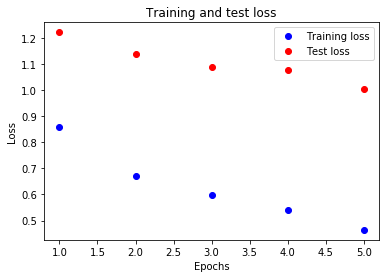

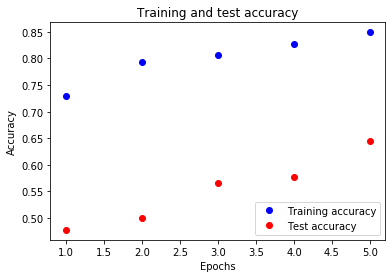

In [19]:
plot_history(history)

In [12]:
feature_extraction = NASNetLarge(weights='imagenet', include_top=False, input_shape=(input_height, input_width, 3))

model2 = models.Sequential()
model2.add(feature_extraction)
model2.add(layers.GlobalAveragePooling2D())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(num_classes, activation='softmax'))
freezeUptoLayer = "normal_add_1_15"

print("\ntrainable layers before unfreezing the base network up to " + freezeUptoLayer + ": ", int(len(model2.trainable_weights) / 2)) 
feature_extraction.trainable = True
set_trainable = False
for layer in feature_extraction.layers:
    if layer.name == freezeUptoLayer: set_trainable = True
    if set_trainable: layer.trainable = True
    else: layer.trainable = False
print("trainable layers after the base network unfreezed from layer " + freezeUptoLayer + ": ", int(len(model2.trainable_weights)/2))


trainable layers before unfreezing the base network up to normal_add_1_15:  510
trainable layers after the base network unfreezed from layer normal_add_1_15:  71


In [13]:
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate, decay=lr_decay), metrics=['acc'])

callbacks = [ModelCheckpoint(filepath=weights_path, save_weights_only=True, monitor='val_acc', verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_acc', factor=factor, patience=patience, verbose=1)]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 4032)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1032448   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1542      
Total params: 85,950,808
Trainable params: 31,197,382
Non-trainable params: 54,753,426
_________________________________________________________________


In [16]:
history2 = model2.fit_generator(
    train_generator,
    steps_per_epoch=42000 // (batch_size *  10),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_generator,
    validation_steps=90,
    verbose=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
65/65 [==============================] - 1578s 24s/step - loss: 0.1234 - acc: 0.9611 - val_loss: 1.1351 - val_acc: 0.7222

Epoch 00001: val_acc improved from -inf to 0.72222, saving model to /content/drive/My Drive/weights/weights_temp.h5
Epoch 2/5
65/65 [==============================] - 1602s 25s/step - loss: 0.0661 - acc: 0.9810 - val_loss: 0.8987 - val_acc: 0.7444

Epoch 00002: val_acc improved from 0.72222 to 0.74444, saving model to /content/drive/My Drive/weights/weights_temp.h5
Epoch 3/5
65/65 [==============================] - 1628s 25s/step - loss: 0.0556 - acc: 0.9817 - val_loss: 1.5377 - val_acc: 0.6667

Epoch 00003: val_acc did not improve from 0.74444

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 4/5
65/65 [==============================] - 1668s 26s/step - loss: 0.0338 - acc: 0.9880 - val_loss: 1.2456 - val_acc: 0.7222

Epoch 

Test accuracy: 0.7444444444444445


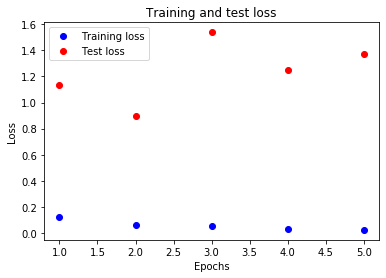

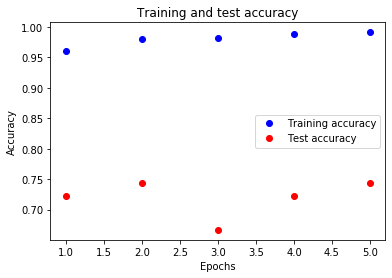

In [17]:
model2.load_weights(weights_path)
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate, decay=lr_decay), metrics=['acc'])
model2.save(os.path.join(models_path, 'finetuned.h5'))
test_loss, test_acc = model2.evaluate_generator(test_generator)

print('Test accuracy:', test_acc)
plot_history(history2)

In [0]:
trained_model = load_model(os.path.join(models_path, 'finetuned.h5'))

In [0]:

def test_model(model, num_images):
    images_so_far = 0
    fig = plt.figure(num_images, (20,20))

    for i, (image, labels) in enumerate(test_generator):
        # Get ground truth
        actual = class_labels[np.argmax(labels)]

        # Predict on image and get label from classes array
        output = trained_model.predict(image)
        pred = class_labels[np.argmax(output)]

        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('Actual: {} \n Prediction: {}'.format(actual, pred))
        
        plt.imshow(image[0])
        if images_so_far == num_images:
            return

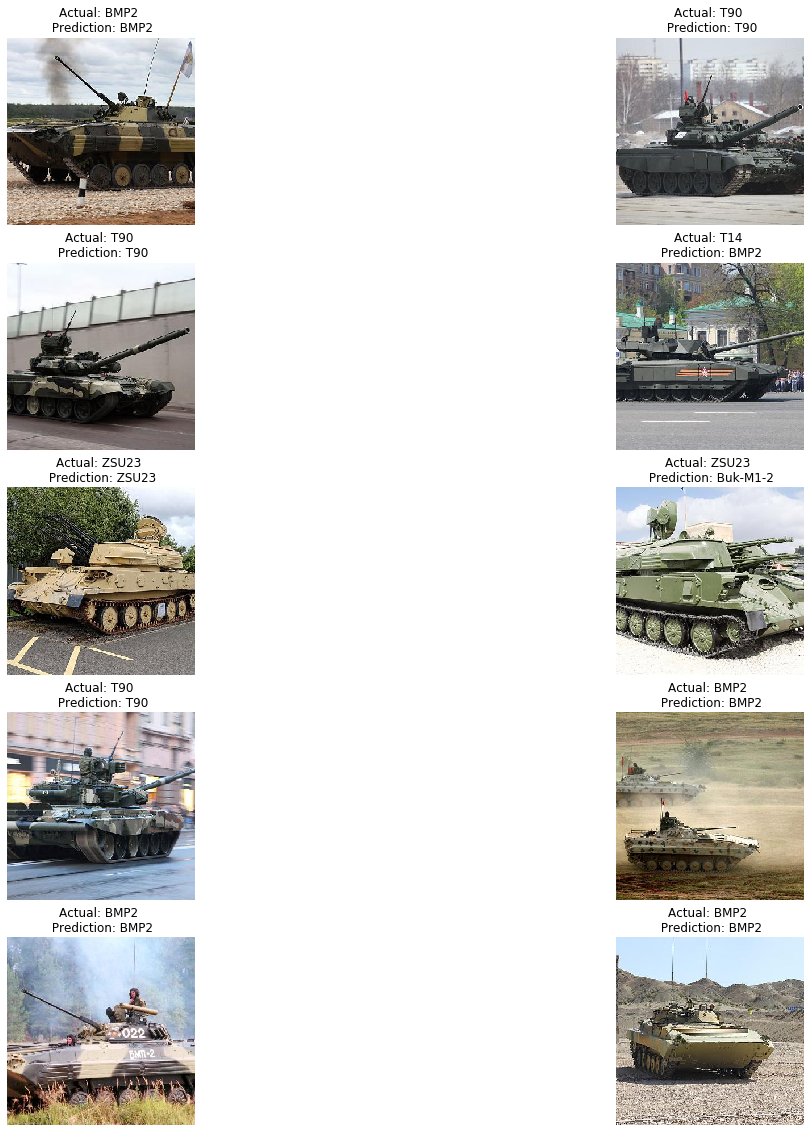

In [20]:
test_model(trained_model, 10)